# Semantic Segmentation Using DeepLab

In [58]:
# loading libraries
import numpy as np
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime


import itertools
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix

import torchvision
import warnings
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler 
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import DataLoader  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda:0


# Data Loading

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
im_size = 56*1

x_transform =  transforms.Compose([#transforms.ToPILImage(),
                    transforms.Resize(im_size),
                    transforms.CenterCrop(im_size),
                    transforms.ToTensor(), 
                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

y_transform =  transforms.Compose([#transforms.ToPILImage(),
                    transforms.Resize(im_size),
                    transforms.CenterCrop(im_size),
                    transforms.ToTensor()
                    ])

In [3]:
batch_size = 32

In [4]:
train_dataset = datasets.VOCSegmentation(root="../dataset/", year='2012', image_set='train', 
                                             download=False, transform=x_transform, target_transform=y_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

test_dataset = datasets.VOCSegmentation(root="../dataset/", year='2012', image_set='val', 
                                             download=False, transform=x_transform, target_transform=y_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

In [5]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True)

In [6]:
criterion = nn.CrossEntropyLoss(ignore_index=255) # ignore (instance) contour
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)

In [7]:
def accuracy(out,labels):
    im = out.argmax(1) # [batch_size x classes x H x W] -> [batch_size x H x W]
    correct = 0
    correct += (out.argmax(1) == labels).sum() # for each pixel check if match

    return 100*correct/(im_size*im_size*batch_size)

In [95]:
class RunningConfusionMatrix():
    def __init__(self, labels, ignore_label=255):
        
        self.labels = labels
        self.ignore_label = ignore_label
        self.overall_confusion_matrix = None
        self.SMOOTH = 1e-6
        
    def update_matrix(self, ground_truth, prediction):
        # if (ground_truth == self.ignore_label).all():
        #     return
        
        current_confusion_matrix = confusion_matrix(y_true=ground_truth,
                                                    y_pred=prediction,
                                                    labels=self.labels)
        
        if self.overall_confusion_matrix is not None:
            
            self.overall_confusion_matrix += current_confusion_matrix
        else:
            
            self.overall_confusion_matrix = current_confusion_matrix
    
    def compute_current_mean_intersection_over_union(self):
        
        intersection = np.diag(self.overall_confusion_matrix)
        ground_truth_set = self.overall_confusion_matrix.sum(axis=1)
        predicted_set = self.overall_confusion_matrix.sum(axis=0)
        union =  ground_truth_set + predicted_set - intersection

        intersection_over_union = (intersection + self.SMOOTH) / (union.astype(np.float32) + self.SMOOTH)
        mean_intersection_over_union = np.mean(intersection_over_union)
        
        return mean_intersection_over_union

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [63]:
# confusion matrix
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# cm = RunningConfusionMatrix(labels=labels, ignore_label=255)

In [64]:
images, targets = next(iter(train_loader))
out = model(images)['out']

Confusion matrix, without normalization


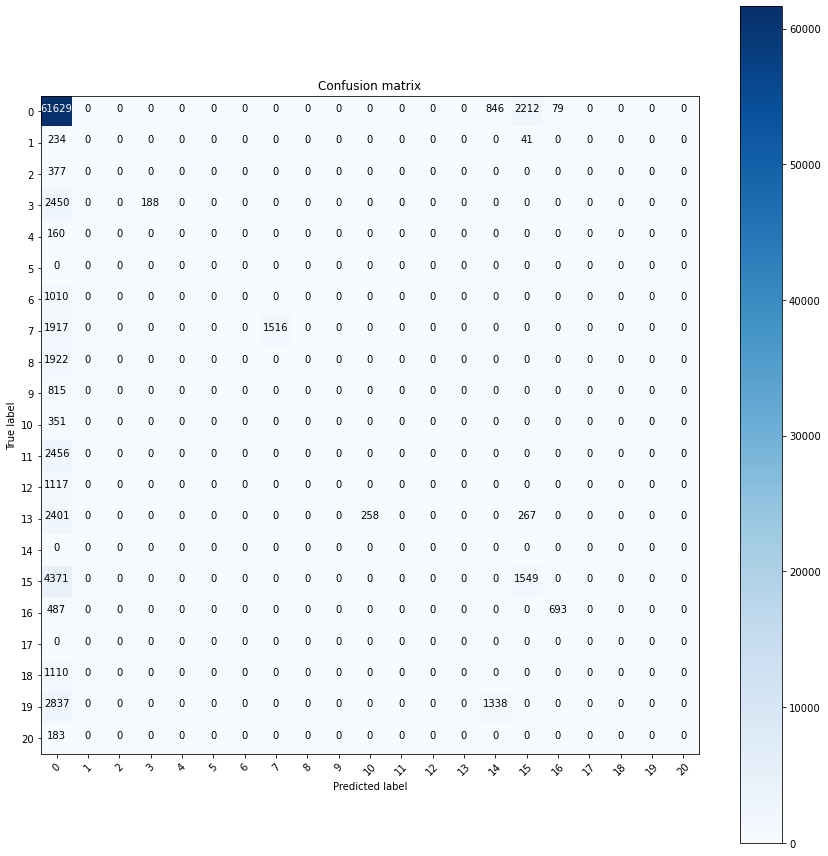

In [65]:
cm = confusion_matrix(tr.view(-1), o.view(-1), labels = labels)
plot_confusion_matrix(cm, classes = labels)

In [69]:
cm = RunningConfusionMatrix(labels = labels)

In [83]:
images, targets = next(iter(train_loader))
tr = targets * 255
model.cpu()
out = model(images)['out']

# cm.compute_current_mean_intersection_over_union()

In [80]:
print(targets.view(-1).shape)
print(out.argmax(1).view(-1).shape)

torch.Size([100352])
torch.Size([100352])


In [91]:
cm.update_matrix(tr.view(-1), out.argmax(1).view(-1))

Confusion matrix, without normalization
nan


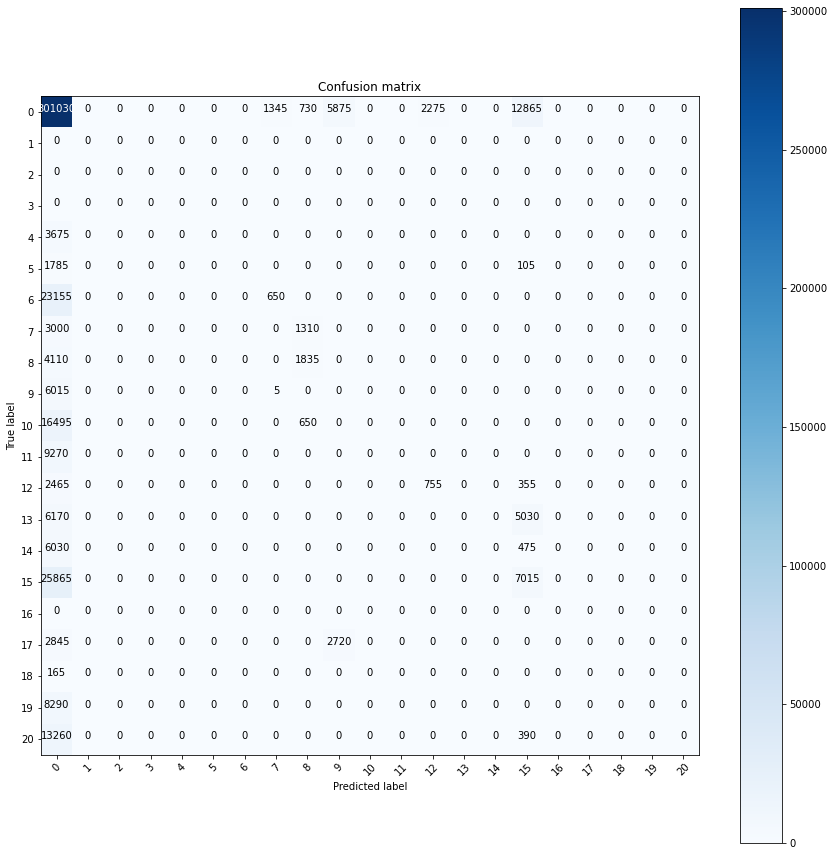

In [96]:
plot_confusion_matrix(cm.overall_confusion_matrix,labels)
print(cm.compute_current_mean_intersection_over_union())

## Training

In [ ]:
%%time

num_epochs = 1

model.to(device)
model.train()
for epoch in range(num_epochs):
    losses = []
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (data, targets) in loop:

        data = data.to(device=device)
        if (int(targets.max()) == int(1)): # scale from [0,1] -> [0,255]
            targets = targets*255
        targets = targets.squeeze(1).to(device=device, dtype=torch.int64)
        
        # forward pass
        out = model(data)['out']
        loss = criterion(out, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()

        # update confusion matrix
        cm.update_matrix(targets.cpu(), out.cpu())

        # update progress bar
        acc = accuracy(out, targets)
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss = loss.item(), acc=f"{acc:.0f}%")


    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")

# Testing

In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
def test(model, test_loader, batch_size=batch_size, overlay=False):
    model.eval()
    image, target = next(iter(test_loader))
    if (int(target.max()) == int(1)):
        target = target*255
    out = model(image)['out']


    for idx in range(batch_size):
        
        om = torch.argmax(out[idx].squeeze(), dim=0).detach().cpu().numpy()

        input_image  = image[idx].permute(1,2,0) * std[0] + torch.FloatTensor(mean)
        target_image = decode_segmap(target[idx].squeeze(0))
        output_image = decode_segmap(om)

        if (overlay):
            axes=[]
            fig=plt.figure(figsize=(6,6))
            plt.imshow(torch.FloatTensor(output_image) * 0.0033 + input_image * 0.65 )
            plt.show()
        else:
            axes=[]
            fig=plt.figure(figsize=(21,21))
            axes.append( fig.add_subplot(1, 3, 1) )
            plt.imshow( input_image  )
            axes[-1].set_title("input")

            axes.append( fig.add_subplot(1, 3, 2) )
            plt.imshow( target_image )
            axes[-1].set_title("target")

            axes.append( fig.add_subplot(1, 3, 3) )
            plt.imshow( output_image )
            axes[-1].set_title("output")

            plt.show()
        
    fig.tight_layout()
    model.train()   


In [ ]:
test(model.cpu(), test_loader, overlay=True )

In [ ]:
# palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
# colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
# colors = (colors % 255).numpy().astype("uint8")

# # plot the semantic segmentation predictions of 21 classes in each color
# r = Image.fromarray(out[0].argmax(0).byte().cpu().numpy()).resize(im.size)
# r.putpalette(colors)

# import matplotlib.pyplot as plt
# plt.imshow(r)

In [ ]:
labels = ["0: background", "1: aeroplane", "2: bicycle", "3: bird", "4: boat", "5: bottle", "6: bus", "7: car", "8: cat", "9: chair", "10: cow", "11: dining table", "12: dog", "13: horse", "14: motorbike", "15: person ","16: potted plant", "17: sheep", "18: sofa", "19: train", "20: tv/monitor"]

width = 2
height = 2
rows = 6
cols = 7

axes=[]
fig=plt.figure(figsize=(13,13))

for a in range(21):
    # b = np.random.randint(7, size=(height,width))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(str(labels[a]))
    axes[-1].set_title(subplot_title,fontweight="bold")
    z = np.array([[a, a],[a, a]])
    plt.imshow(decode_segmap(z))
    plt.axis('off')  
# fig.tight_layout()    
plt.show()


In [ ]:
# torch.save(model.state_dict(), 'model1.ckpt')